In [1]:
import numpy as np
import torch
from bisect import bisect
import os, psutil # used to monitor memory usage
from glob import glob
import pylab as pl
from PIL import Image

from tqdm.notebook import tqdm

In [2]:
from torch            import FloatTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision      import transforms, models
from torch.nn         import functional as F

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
params = {'legend.fontsize': '20',
          'figure.figsize': (7, 7),
          'figure.facecolor': 'white',
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'figure.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'axes.labelpad' : '20'}
pl.rcParams.update(params)

In [4]:
def norm(x):
    return (x - np.mean(x) )/np.std(x)

def wnorm(x,w):
    std_weighted = np.sqrt(np.average((x-np.average(x, weights=w))**2, weights=w))
    x = (x - np.sum(x*w)/np.sum(w))/std_weighted    

In [5]:
class ReadDataset(Dataset):

    def __init__(self, photo_paths, spec_paths, target_paths):
        self.photo_files = photo_paths
        self.spec_files = spec_paths
        self.target_files = target_paths
        
        self.photo_transforms = transforms.Compose([
            # transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __getitem__(self, index):
        x1 = np.load(self.photo_files[index])
        x1 = self.photo_transforms(x1)
        
        x2 = np.load(self.spec_files[index])
        x2 = norm(x2)
        x2 = FloatTensor(x2).view(-1,len(x2))
        
        y = np.load(self.target_files[index])[0] #- Get only the first feature 0:Redshift
        y = torch.tensor(y).float()
        
        return x1, x2, y
    
    def __len__(self):
        return len(self.target_files)

In [6]:
def tensor2img(tensor):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    img_restore = tensor * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return transforms.ToPILImage()(img_restore)

### Preparing the data

In [7]:
# Test Code
#- Path to all the image files
images = np.sort(glob('./catalog_fuji_sv3_bgs/npy/*photogrz*.npy'))[:10000]
spects = np.array([i.replace('photogrz','fluxbrz') for i in images])
targets = np.array([i.replace('photogrz','features') for i in images])
    
#- Filtered by redshift
images_filtered_by_Z = []
spects_filtered_by_Z = []
targets_filtered_by_Z = []
Z_max=0.5

for img, spc, tgt in zip(images, spects, targets):
    Z = np.load(tgt)[0] #- Get only the first feature 0:Redshift
    if Z < Z_max:
        images_filtered_by_Z.append(img)
        spects_filtered_by_Z.append(spc)
        targets_filtered_by_Z.append(tgt)

images = np.array(images_filtered_by_Z)
spects = np.array(spects_filtered_by_Z)
targets = np.array(targets_filtered_by_Z)

#- Number of objects
N = len(images)
print(f'#####\n There are {N} objects\n#####')

ii       = np.random.choice(range(N), N, replace=False)
ii_train = ii[:int(N*.7)]
ii_valid  = ii[int(N*.7):int(N*.9)]
ii_test  = ii[int(N*.9):]

img_train_files = images[ii_train]
spc_train_files = spects[ii_train]
tgt_train_files = targets[ii_train]

img_valid_files = images[ii_valid]
spc_valid_files = spects[ii_valid]
tgt_valid_files = targets[ii_valid]

img_test_files = images[ii_test]
spc_test_files = spects[ii_test]
tgt_test_files = targets[ii_test]

print(f'#####\n Train Size: {len(img_train_files)}')
print(f'Valid Size: {len(img_valid_files)}')
print(f'Test Size:{len(img_test_files)}\n#####')

train_dataset = ReadDataset(img_train_files, spc_train_files, tgt_train_files)
valid_dataset = ReadDataset(img_valid_files, spc_valid_files, tgt_valid_files)
test_dataset  = ReadDataset(img_test_files, spc_test_files, tgt_test_files)

#####
 There are 9545 objects
#####
#####
 Train Size: 6681
Valid Size: 1909
Test Size:955
#####


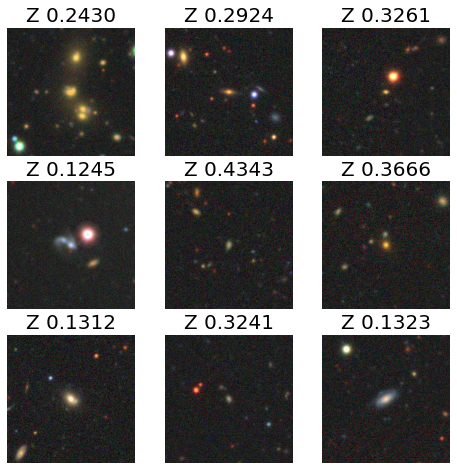

In [8]:
figure = pl.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, spc, tgt = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    pl.title(f'Z {tgt:.4f}')
    pl.axis("off")
    pl.imshow(tensor2img(img))
pl.show()

In [9]:
#- Define the batch_size
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset,  batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

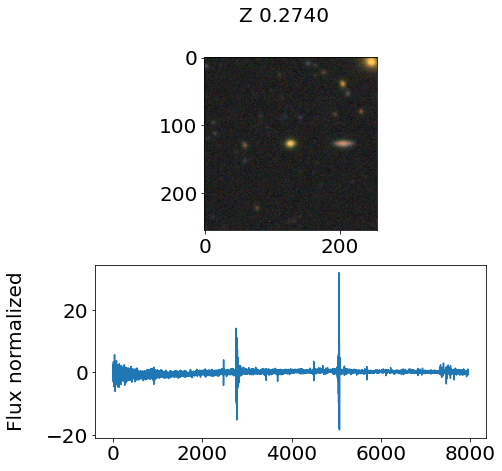

In [10]:
# Display image and label.
train_photo_features, train_spec_features, train_labels = next(iter(train_dataloader))
img = train_photo_features[0].squeeze()
spc = train_spec_features[0].squeeze()
label = train_labels[0]
pl.suptitle(f'Z {label:.4f}')
pl.subplot(2,1,1)
pl.imshow(tensor2img(img))
pl.subplot(2,1,2)
pl.plot(spc)
pl.ylabel('Flux normalized')
pl.show()

### Load the model

In [11]:
# model = models.resnet152(pretrained=True)
# # model

In [12]:
# count = 0
# for child in model.children():    
#     count+=1
# print(count)

In [13]:
# count = 0
# for child in model.children():  
#     count+=1
#     if count < 7:    
#         for param in child.parameters():
#             param.requires_grad = False

In [14]:
class DeepGalaxyNet(torch.nn.Module):
    def __init__(self, pretrained=True, model='resnet50', dropout=0.3, out_channels=100):
        super().__init__()
                
        model = models.resnet18(pretrained=pretrained)
        
        count = 0
        for child in model.children():  
            count += 1
            if count < 7:    
                for param in child.parameters():
                    param.requires_grad = False
                    
        model.load_state_dict(model.state_dict())        
            
        self.features = torch.nn.ModuleList(model.children())[:-1]
        self.features = torch.nn.Sequential(*self.features)
        
        self.photo_fc1 = torch.nn.Linear(model.fc.in_features, 512)
        self.photo_fc2 = torch.nn.Linear(512, 256)
       
        self.spec_conv1d1 = torch.nn.Conv1d(1, out_channels=out_channels, kernel_size=10, stride=2, padding=0)
        self.spec_batch1 = torch.nn.BatchNorm1d(out_channels)           
        self.spec_conv1d2 = torch.nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=10, stride=2, padding=0)
        self.spec_batch2 = torch.nn.BatchNorm1d(out_channels)
        self.spec_conv1d3 = torch.nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=10, stride=2, padding=0)
        self.spec_batch3 = torch.nn.BatchNorm1d(out_channels)
        self.spec_conv1d4 = torch.nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=10, stride=2, padding=0)
        self.spec_batch4 = torch.nn.BatchNorm1d(out_channels)
        self.spec_fc1 = torch.nn.Linear(48900, 580)
        self.spec_fc2 = torch.nn.Linear(580, 290)

        self.fc3 = torch.nn.Linear(256+290, 200)
        self.dropout = torch.nn.Dropout(p=dropout)        
        self.fc4 = torch.nn.Linear(200, 200)
        self.fc5 = torch.nn.Linear(200, 1)
        
        
    def forward(self, img, spc):
        
        ## Model on Photo
        #-Call Features
        img = self.features(img)
        #-Flatten
        img = img.view(img.size(0), -1)
        # and also our new layers 
        img = F.relu(self.photo_fc1(img))
        img = F.relu(self.photo_fc2(img))
        
        
        #### Model on Spec
        spc = F.relu(self.spec_batch1(self.spec_conv1d1(spc)))
        spc = F.relu(self.spec_batch2(self.spec_conv1d2(spc)))
        spc = F.relu(self.spec_batch3(self.spec_conv1d3(spc)))   
        spc = F.relu(self.spec_batch4(self.spec_conv1d4(spc)))
        spc = torch.flatten(spc,1)
        spc = F.relu(self.spec_fc1(spc))
        spc = F.relu(self.spec_fc2(spc))
        
        
        
        x = F.relu(self.fc3(torch.cat([img, spc], dim=1)))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        return x

In [15]:
model = DeepGalaxyNet()
# model

In [16]:
#- Define the device cpu/gpu
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [17]:
#- Define metrics
losses_train = []
losses_valid = [0]
best_loss    = 100

#- Send the model to the device
model = model.to(device)

#- Define the optimizer and the criterion
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #SGD
criterion = torch.nn.MSELoss()

#- Define the number of epochs
n_epochs = 2 #100

#- Parameter that count iterations
it = 0

#- Start the train loop
pbar = tqdm(total=n_epochs)
for epoch in range(n_epochs):
    
    #- Set the model in train mode
#     model.eval()
#     with torch.no_grad():
#         for batch_id, (X_valid_batch, Y_valid_batch) in enumerate(valid_dataloader):
#             #- Send data to device 
#             # X_test_batch = FloatTensor(X_test_batch)
#             X_valid_batch = X_valid_batch.to(device)

#             # Y_test_batch = FloatTensor(Y_test_batch).view(len(Y_test_batch), -1)
#             Y_valid_batch = Y_valid_batch.to(device)

#             #- make a prediction
#             Y_pred = model(X_valid_batch).squeeze()
#             # print(Y_pred.size())
            
#             #- Compute the loss
#             loss = criterion(Y_pred, Y_valid_batch)
#     losses_valid.append(loss.item())
    
    #- Set the model in train mode
    model.train()
    for batch_id, (X1_train_batch, X2_train_batch, Y_train_batch) in enumerate(train_dataloader):
        #- Send data to device 
        # X_train_batch = FloatTensor(X_train_batch)
        X1_train_batch = X1_train_batch.to(device)
        
        X2_train_batch = X2_train_batch.to(device)
        
        # Y_train_batch = FloatTensor(Y_train_batch).view(len(Y_train_batch), -1)
        Y_train_batch = Y_train_batch.to(device)

        #- make a prediction
        Y_pred = model(X1_train_batch, X2_train_batch).squeeze()
        
        #- Compute the loss
        loss = criterion(Y_pred, Y_train_batch)
        # print(loss.item())
        
        #- Back Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_train.append(loss.item())
    print(f'Epoch:{epoch+1} - Iter:{it+1} - Loss_Train:{losses_train[-1]:.4f} - Loss_Test:{losses_valid[-1]:.4f}')
       
        
    if losses_train[-1] < best_loss:
        torch.save(model, './model/spec_Z_pred.pt')
        best_loss = losses_train[-1]
            
    # del X_train_batch, Y_train_batch, X_test_batch, Y_test_batch, Y_pred

    pbar.update()
pbar.close()

0.04118786007165909
0.02899552509188652
0.01764724776148796
0.015854481607675552
0.016678906977176666
0.016636718064546585
0.009125864133238792
0.012103240936994553
0.01277074869722128
0.00851698312908411
0.01440533995628357
0.015410839579999447
0.011877025477588177
0.010380065068602562
0.009861171245574951
0.015506677329540253
0.00952980201691389
0.018744150176644325
0.012684185989201069
0.012513936497271061
0.015585564076900482
0.016420071944594383
0.011861058883368969
0.00673094904050231
0.012573011219501495
0.013537347316741943
0.019721411168575287
0.017140012234449387
0.009805633686482906
0.01245177909731865
0.012093847617506981
0.011917747557163239
0.014829966239631176
0.01642010733485222
0.009577280841767788
0.023136308416724205
0.010199952870607376
0.01459590345621109
0.010004548355937004
0.009233835153281689
0.012121445499360561
0.013824965804815292
0.01437982078641653
0.008041445165872574
0.012278168462216854
0.013487543910741806
0.011817382648587227
0.01213828194886446
0.007

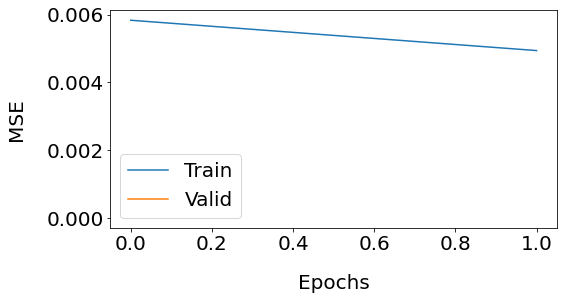

In [18]:
fig = pl.figure(figsize=(8,4))
pl.plot(losses_train, label='Train')
pl.plot(losses_valid, label='Valid')
pl.xlabel('Epochs')
pl.ylabel('MSE')
pl.legend()
pl.show()

In [21]:
#- Put the model on test mode
model.eval()
with torch.no_grad():
    Y_pred = []
    Y_test = []
    for batch_idx, (data_phot, data_spec, target) in enumerate(test_dataloader):    
        data_phot = FloatTensor(data_phot)
        data_spec = FloatTensor(data_spec)
        target = FloatTensor(target)
        
        data_phot   = data_phot.to(device)
        data_spec   = data_spec.to(device)
        target = target.to(device)
        
        Y_pred.append(model(data_phot, data_spec).cpu().squeeze().detach().numpy())
        Y_test.append(target.cpu().detach().numpy())    
    Y_predtest = np.concatenate([np.ravel(i) for i in Y_pred])
    Y_test = np.concatenate([np.ravel(i) for i in Y_test])

    Y_pred = []
    Y_train = []    
    for batch_idx, (data_phot, data_spec, target) in enumerate(train_dataloader):    
        data_phot = FloatTensor(data_phot)
        data_spec = FloatTensor(data_spec)
        target = FloatTensor(target)
        
        data_phot   = data_phot.to(device)
        data_spec   = data_spec.to(device)
        target = target.to(device)
        
        Y_pred.append(model(data_phot, data_spec).cpu().squeeze().detach().numpy())
        Y_train.append(target.cpu().detach().numpy())
    Y_predtrain = np.concatenate([np.ravel(i) for i in Y_pred])
    Y_train = np.concatenate([np.ravel(i) for i in Y_train])

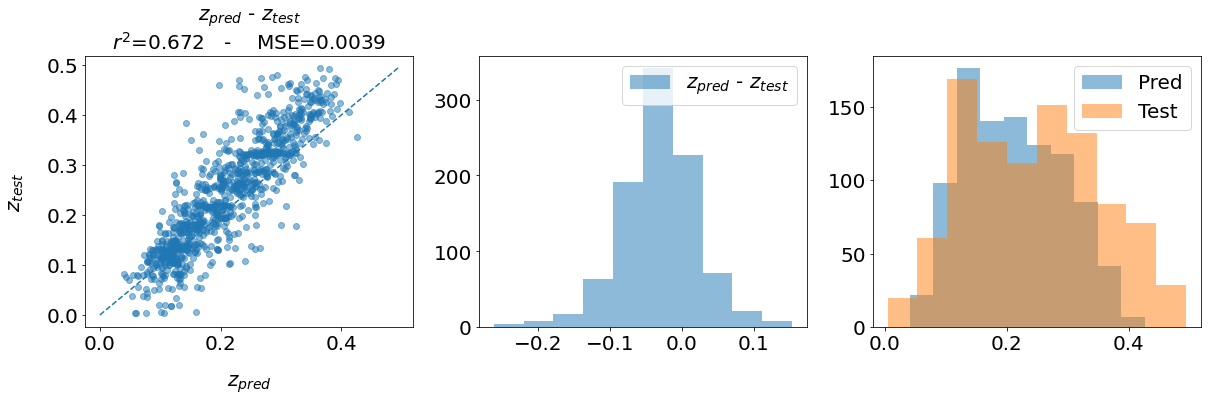

In [22]:
fig = pl.figure(figsize=(20,5))

pl.subplot(1,3,1)
pl.scatter(Y_predtest, Y_test, alpha=0.5)
maxx = max(max(Y_predtest),max(Y_test))
pl.plot([0, maxx], [0, maxx], '--')
pl.xlabel(r'$z_{pred}$')
pl.ylabel(r'$z_{test}$')
pl.title(r'$z_{pred}$ - $z_{test}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_test, Y_predtest):.3f}   -    MSE={mean_squared_error(Y_test, Y_predtest):.4f}')

pl.subplot(1,3,2)
_ = pl.hist(Y_predtest - Y_test, label=r'$z_{pred}$ - $z_{test}$', alpha=0.5)
pl.legend()

pl.subplot(1,3,3)
_ = pl.hist(Y_predtest, label='Pred', alpha=0.5)
_ = pl.hist(Y_test, label='Test', alpha=0.5)
pl.legend()
pl.show()

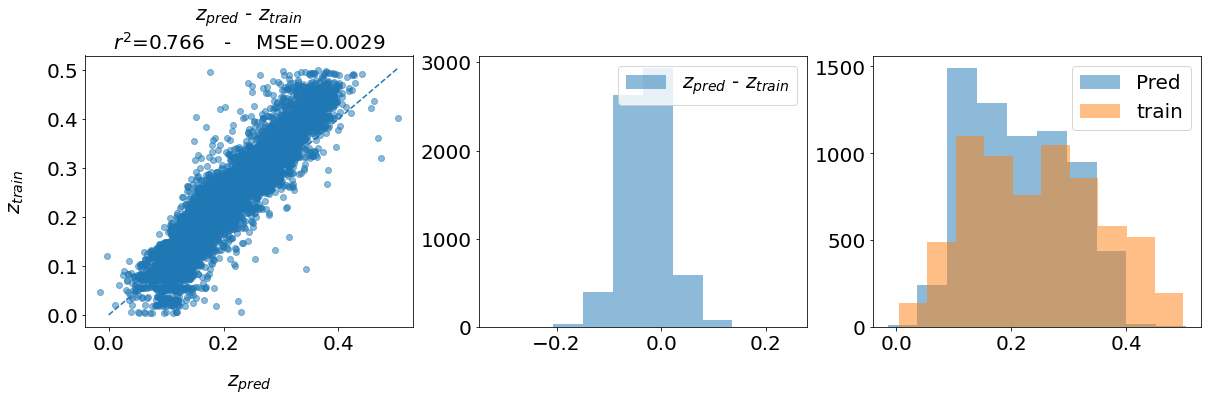

In [23]:
fig = pl.figure(figsize=(20,5))

pl.subplot(1,3,1)
pl.scatter(Y_predtrain, Y_train, alpha=0.5)
maxx = max(max(Y_predtrain),max(Y_train))
pl.plot([0, maxx], [0, maxx], '--')
pl.xlabel(r'$z_{pred}$')
pl.ylabel(r'$z_{train}$')
pl.title(r'$z_{pred}$ - $z_{train}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_train, Y_predtrain):.3f}   -    MSE={mean_squared_error(Y_train, Y_predtrain):.4f}')

pl.subplot(1,3,2)
_ = pl.hist(Y_predtrain - Y_train, label=r'$z_{pred}$ - $z_{train}$', alpha=0.5)
pl.legend()

pl.subplot(1,3,3)
_ = pl.hist(Y_predtrain, label='Pred', alpha=0.5)
_ = pl.hist(Y_train, label='train', alpha=0.5)
pl.legend()
pl.show()

In [24]:
model

DeepGalaxyNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat